# Results of 10 runs of PPO
Linear version (non-recurrent).

In [1]:
from datetime import datetime
from dataclasses import dataclass
from marlenv import Episode
from functools import cached_property
from banksys import Transaction
from environment import Action
import logging

@dataclass
class LogItem:
    episode: Episode

    @cached_property
    def t_start(self):
        return datetime.fromisoformat(self.episode.metrics["t_start"])

    @cached_property
    def t_end(self):
        return datetime.fromisoformat(self.episode.metrics["t_end"])

    @cached_property
    def terminal_ids(self) -> list[int]:
        terminals = self.episode.metrics["terminals"]
        if len(self.episode) != len(terminals):
            #logging.warning(f"There are {len(self.episode)} transitions but {len(terminals)} terminals. Padding with 0s.")
            terminals = terminals + [0] * (len(self.episode) - len(terminals))
        return terminals

    @cached_property
    def card_id(self) -> int:
        return self.episode.metrics["card_id"]

    @cached_property
    def total_amount(self):
        return sum(t.amount for t in self.transactions)

    @cached_property
    def transactions(self):
        res = list[Transaction]()
        t = self.t_start
        for i, transition in enumerate(self.episode.transitions()):
            action = Action.from_numpy(transition.action)
            t = t + action.timedelta
            res.append(Transaction(action.amount, t, self.terminal_ids[i], self.card_id, action.is_online, None))
        return res


In [2]:
import orjson
import numpy as np

def get_logs(file_path: str):
    with open(file_path, "rb") as f:
        episodes = orjson.loads(f.read())
    logs = list[LogItem]()
    for e_dict in episodes[:4000]:
        assert isinstance(e_dict, dict)
        try:
            e_dict.pop("score")
        except:
            DEBUG=0
        for key, value in e_dict.items():
            if isinstance(value, list):
                e_dict[key] = [np.array(l) for l in value]
        e_dict = Episode(**e_dict)
        logs.append(LogItem(e_dict))
    return logs

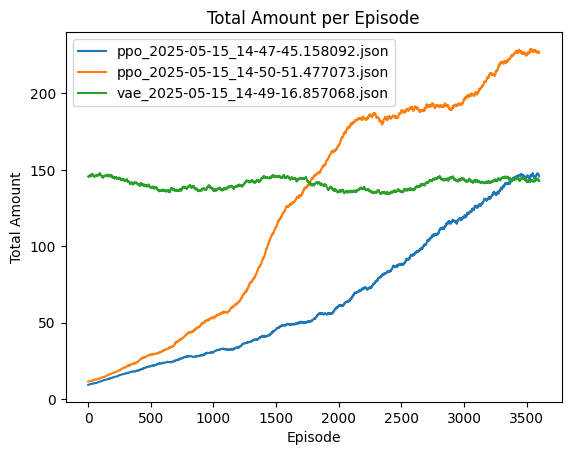

In [3]:
import matplotlib.pyplot as plt
import os

logs = dict[str, list[LogItem]]()
for log_file in os.listdir("logs/tests"):
    logs[log_file] = get_logs(os.path.join("logs/tests",  log_file)) #"ppo",

for path, log in logs.items():
    amounts = [t.total_amount for t in log]
    # Compute the moving average over 50 episodes
    window_size = 400
    amounts = np.convolve(amounts, np.ones(window_size) / window_size, mode='valid')
    plt.plot(amounts, label=path)
    
plt.xlabel("Episode")
plt.ylabel("Total Amount")
plt.title("Total Amount per Episode")
plt.legend()



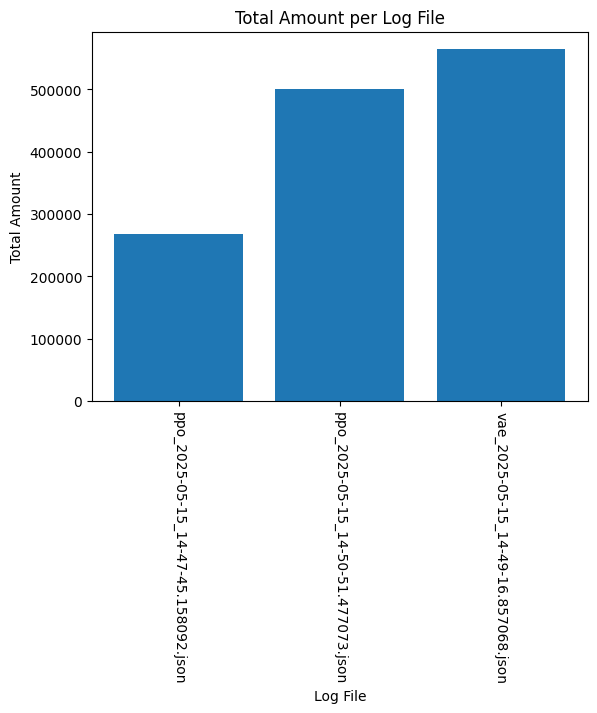

In [4]:
amounts = []
labels = []
for path, log in logs.items():
    amounts.append(sum(i.total_amount for i in log))
    labels.append(path)
plt.bar(labels, amounts)
plt.xlabel("Log File")
plt.ylabel("Total Amount")
plt.title("Total Amount per Log File")
plt.xticks(rotation=-90)
plt.show()


{'whiskers': [<matplotlib.lines.Line2D at 0x1c62a6bf760>,
 'caps': [<matplotlib.lines.Line2D at 0x1c62a6ad690>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c62a6bf4c0>,
 'medians': [<matplotlib.lines.Line2D at 0x1c62a6ac4c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c62a6ad450>,
 'means': [<matplotlib.lines.Line2D at 0x1c62a6ac9a0>,
  <matplotlib.lines.Line2D at 0x1c62a675870>]}

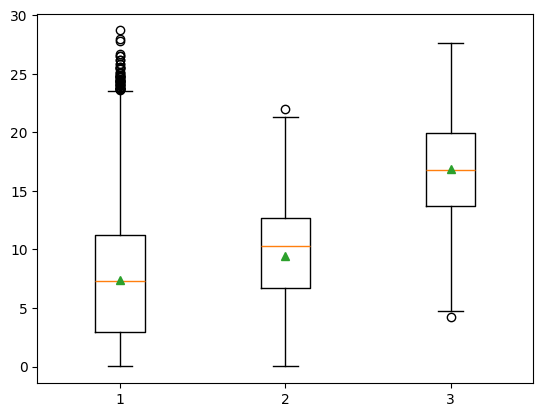

In [5]:
import numpy as np
all_amounts = []
all_n_transactions = []
labels = []
for path, episodes in logs.items():
    amounts = []
    n_transactions = []
    labels.append(path)
    for episode in episodes:
        n_transactions.append(len(episode.transactions))
        for t in episode.transactions:
            amounts.append(t.amount)
    all_amounts.append(amounts)
    all_n_transactions.append(n_transactions)
plt.boxplot(all_amounts, showmeans=True, showfliers=True, label=labels)
# plt.legend()



{'whiskers': [<matplotlib.lines.Line2D at 0x1c62a6f99c0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c62a6f9f00>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c62a6f9720>,
 'medians': [<matplotlib.lines.Line2D at 0x1c62a6fa320>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c62a6fa860>,
 'means': [<matplotlib.lines.Line2D at 0x1c62a6fa5c0>,
  <matplotlib.lines.Line2D at 0x1c62a719000>]}

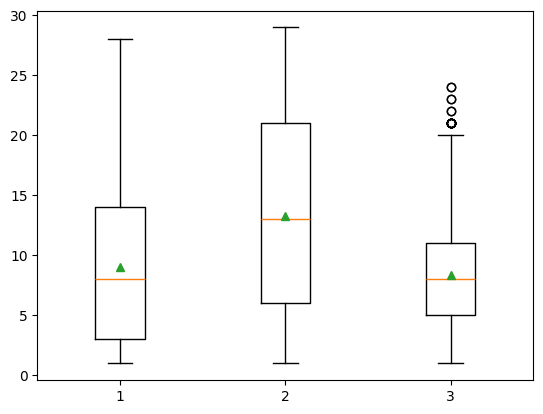

In [6]:
plt.boxplot(all_n_transactions, showfliers=True, showmeans=True)